In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw6.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science
## Homework 6: Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2pt">



In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Decision Tree**](#part1)


- [**Question 2: Bagging**](#part2) 


- [**Question 3: Random Forests**](#part3) 


- [**Question 4: Boosting**](#part4) 


<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)


### Higgs boson discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

### Data description

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

### Loading the data

Run the following cell to load the data. Do not modify this code. We need to ensure everyone has the exact same arrays for this homework.

**Note:** If you have issues passing some of the test cases it may be due to your version of SKLearn. Try running your notebook on the OneDemand Jupyter service linked from Canvas where everyone has access to a standardized Python environment.

In [4]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

data_train = pd.read_csv("data/Higgs_train.csv")
data_test = pd.read_csv("data/Higgs_test.csv")

print(
    f"Our data contains {len(data_train):,} training samples "
    f"and {len(data_test):,} test samples.\n"
)

print("TRAINING DATA INFORMATION:\n")
data_train.info()

print("\nTRAINING DATA HEAD:")
display(data_train.head())

print("\nTRAINING DATA SUMMARY STATISTICS:")
display(data_train.describe())

# Split dataframe into X and y numpy arrays
X_train = data_train.iloc[:, data_train.columns != "class"].values
y_train = data_train["class"].values
X_test = data_test.iloc[:, data_test.columns != "class"].values
y_test = data_test["class"].values

Our data contains 5,000 training samples and 5,000 test samples.

TRAINING DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lepton pT                 5000 non-null   float64
 1   lepton eta                5000 non-null   float64
 2   lepton phi                5000 non-null   float64
 3   missing energy magnitude  5000 non-null   float64
 4   missing energy phi        5000 non-null   float64
 5   jet 1 pt                  5000 non-null   float64
 6   jet 1 eta                 5000 non-null   float64
 7   jet 1 phi                 5000 non-null   float64
 8   jet 1 b-tag               5000 non-null   float64
 9   jet 2 pt                  5000 non-null   float64
 10  jet 2 eta                 5000 non-null   float64
 11  jet 2 phi                 5000 non-null   float64
 12  jet 2 b-tag             

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0



TRAINING DATA SUMMARY STATISTICS:


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


<a id="part1"></a>

## <div class='exercise'>Question 1: Decision Tree</div> 
    
[Return to contents](#contents)
    

<div class='exercise-r'>

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, for each tree depth from 1 to 20 (inclusive):

- Fit a decision tree to the entire **training** set. Set `random_state=0`.

- Evaluate on the entire **training** set (i.e., `.score(...)`), while storing the scores in a variable named `train_scores`.

- Perform 5-fold cross-validation with the entire **training** set using [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Store the mean validation score and the validation standard deviation  in variables named `cvmeans` and `cvstds` respectively.

**IMPORTANT:** Throughout this assignment, you should set `random_state=0` in any model that takes such an argument to ensure reproducible results.
</div>

In [5]:
# set random state
random_state = 0

# train_scores, cvmeans, and cv stds variables
train_scores = []
cvmeans = []
cvstds = []
depths = range(1,21)

# get req stats from each depth
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, 
                                random_state=random_state).fit(X_train,y_train)
    train_scores.append(dt.score(X_train, 
                                 y_train))
    cvscores = cross_val_score(estimator=dt, 
                            X=X_train, 
                            y=y_train, 
                            cv=5, 
                            n_jobs=-1)
    cvmeans.append(np.mean(cvscores))
    cvstds.append(np.std(cvscores))

In [6]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**1.2** Now that we have `train_scores`, `cvmeans`, and `cvstds`, let's plot them. Generate 2 plots, both showing (a) the non-cross-validation training scores, (b) the mean validation scores, and (c) a shaded region that illustrates the +/-2 standard deviation validation bounds for each tree depth. The content and formatting of these 2 plots should be identical, EXCEPT in one plot set the limits on the y-axis to focus on the validation performance. Remember to label and title each plot appropropriately.

**HINT:** You can use `plt.fill_between(...)` to easily generate the shaded region in your plots.

</div>

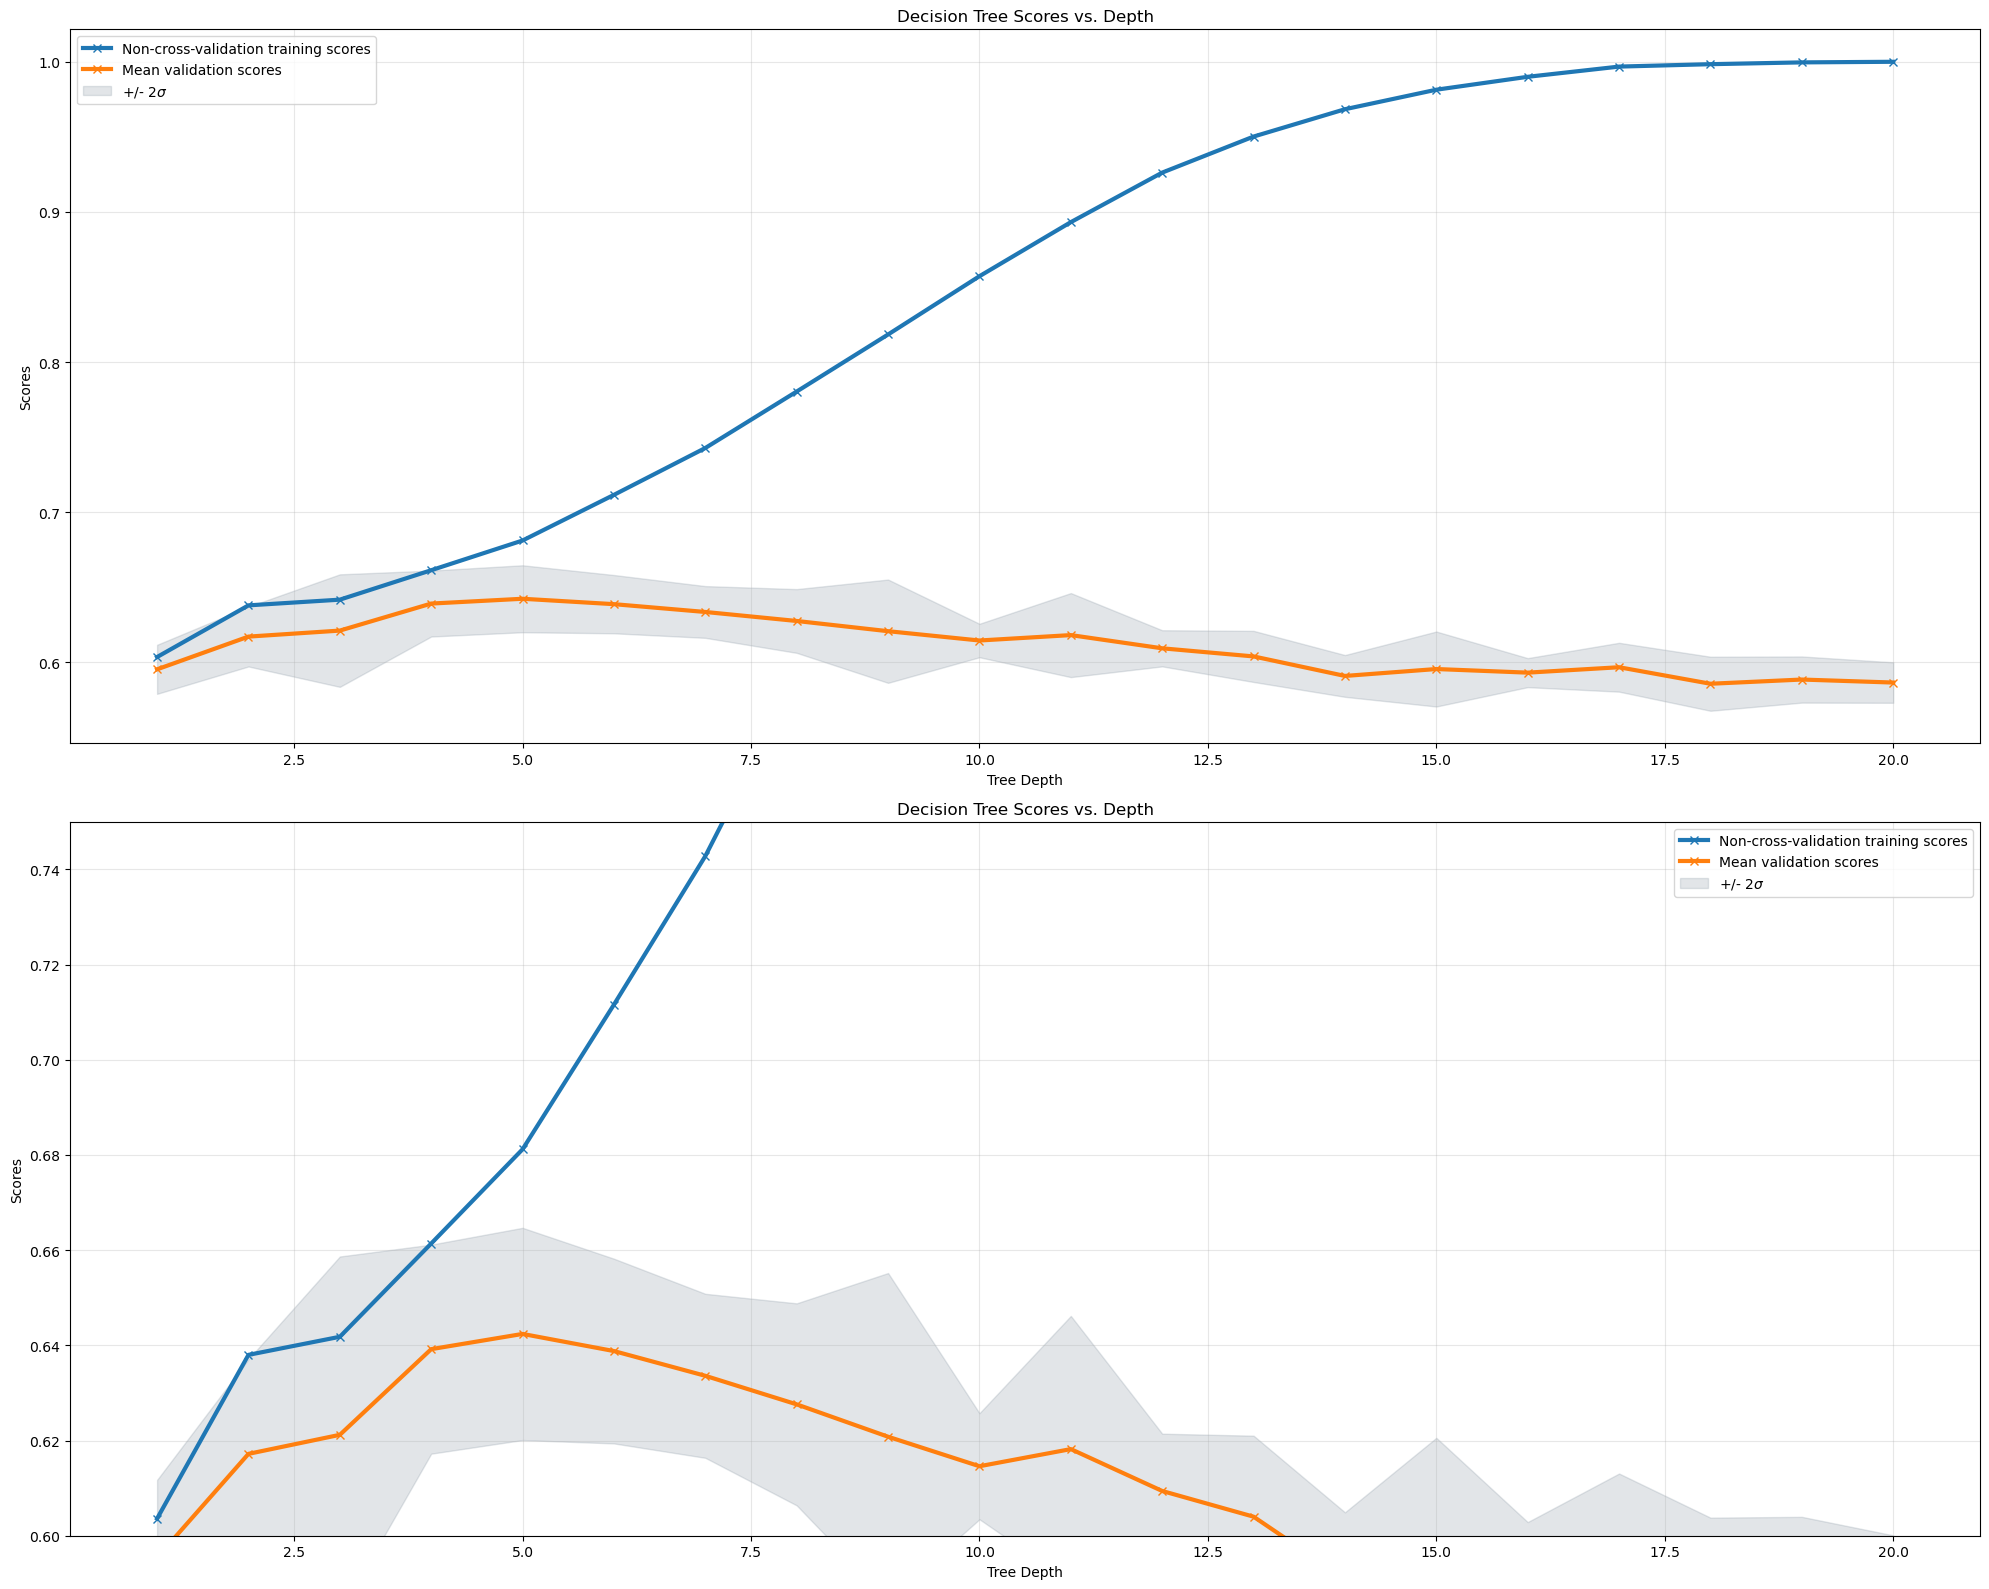

In [7]:
# plot
fig, axes = plt.subplots(2,1, figsize=(20,16))

# flatten axes array
axes.ravel()

# plot the first one
axes[0].plot(depths, 
             train_scores, 
             'x-', 
             label = 'Non-cross-validation training scores', 
             lw = 3)
axes[0].plot(depths, 
             cvmeans, 
             'x-', 
             label = "Mean validation scores", 
             lw = 3)
axes[0].set(xlabel='Tree Depth', 
            ylabel='Scores', 
            title='Decision Tree Scores vs. Depth')
axes[0].fill_between(depths, np.array(cvmeans) + 2 * np.array(cvstds), 
                 np.array(cvmeans) - 2 * np.array(cvstds), 
                 alpha = .2, label = "+/- $2\\sigma$", color = 'slategrey')
axes[0].grid(alpha = 0.3)
axes[0].legend()

# copy and paste, but adjust ylim
axes[1].plot(depths, 
             train_scores, 
             'x-', 
             label = 'Non-cross-validation training scores', 
             lw = 3)
axes[1].plot(depths, 
             cvmeans, 
             'x-', 
             label = "Mean validation scores", 
             lw = 3)
axes[1].set(xlabel='Tree Depth', 
            ylabel='Scores', 
            title='Decision Tree Scores vs. Depth')
axes[1].fill_between(depths, np.array(cvmeans) + 2 * np.array(cvstds), 
                 np.array(cvmeans) - 2 * np.array(cvstds), 
                 alpha = .2, label = "+/- $2\\sigma$", color = 'slategrey')
axes[1].grid(alpha = 0.3)
axes[1].legend()
axes[1].set_ylim(0.6,0.75)
fig.tight_layout();


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, store it in `best_cv_depth`, and **justify your choice**. Then, using this depth, fit a new decision tree on the entire training data and store the train and test accuracies in `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

I think the most appropriate depth to select for future, unseen data is going to be 5. A depth of 5 yielded the highest mean cross-validation score, and a higher score is indicative of a better model in this case. While increasing the depth increases our training score, our cross-validation score deteriorates—likely because more complex decision trees are more prone to overfitting—so the model doesn't generalize well, performing poorly on unseen data. Cross-validation is our robust way of tuning hyperparameters like depth.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [8]:
# your code here
# choose best depth after a qualitative assessment of our plots
best_cv_depth = 5
best_dt = DecisionTreeClassifier(max_depth=best_cv_depth, 
                random_state=random_state).fit(X_train,y_train)

best_cv_tree_train_score = best_dt.score(X_train,y_train)
best_cv_tree_test_score = best_dt.score(X_test,y_test)

In [9]:
# print model results summary
print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 5 trained on the full training set, achieves the following accuracy scores:

	train	0.6812
	TEST	0.6480


<!-- END QUESTION -->

<a id="part2"></a>

## <div class='exercise'>Question 2: Bagging</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.1** Based on your results from [Question 1](#part1solutions), choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below. However, be certain that your final choice and rationale is based on your results from Question 1.)

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

I believe `tree_depth = 20` will overfit. Aside from learning in lecture that increasing a decision tree's depth/complexity increases its likelihood of overfitting, we can see from the graph above that a `depth = 20` has one of the worst cross-validation means, as its cross-validation mean was close to the minimum value of `cvmeans`. Moreover, its training score was 1, which is a typical sign of overfitting. Therefore, a depth of 20 is probably unnecessarily complex, overfitting the training data, and likely to generalize poorly.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [10]:
# set overfitting tree_depth based on provided rationale 
tree_depth = 20

<!-- END QUESTION -->

<div class='exercise-r'>

**2.2** Here we will use the `tree_depth` chosen in Question 2.1 to generate 55 boostrapped sets of decision tree predictions for both the training and test data. To accomplish this:

- **Using a random seed of 0**, call the provided `bagger` function to return your bootstrapped results.
- Store your returned results as: 
  1. `bagging_train_df`: a dataframe containing your training data predictions (see the "required dataframe structure" below)
  2. `bagging_test_df`: a dataframe containing your test data predictions
  3. `bagging_models_list`: a list containing your 55 fitted model objects (i.e. fitted estimators)
- Finally, display the heads of both dataframes.

**NOTE:** There is no need to do anything with your `bagging_models_list` list yet. It will not be used until later in [Question 3.2](#part3).

**DATAFRAME STRUCTURE:** The training and test prediction results of your bootstraps are returned by the `bagger` function as dataframes formatted like the example shown below. Each row represents one observation (from either the training or test set depending on the dataframe), and each column represents one bootstrapped result. The values stored in the dataframe are the bootstrapped predictions for each observation as illustrated below.

An example of the `bagging_train_df` and `bagging_test_df` dataframes would be:

|     |bootstrap model 1|bootstrap model 2|...|bootstrap model 55|  
| --- | --- | --- | --- | --- |
|0| 0 | 1|... |0|
|1| 1| 1|... |0|
|2| 0| 0|... |1|
|...| ...| ...|... |... |
| $n$-1 | 0| 0|... |1|

</div>

In [11]:
def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """Generate boostrapped DecisionTreeClassifier predictions
    
    Function fits bootstrapped DecisionTreeClassifier models
    and returns training and test predictions for each of those
    bootstrapped models, along with the fitted model objects as
    described in Question 2.2 question text.
    
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe
              as described in Q2.2 question text, (2) bagging_test_df
              dataframe as described in Q2.2, and (3) bagging_models_list
              containing every trained DecisionTreeClassifier model
              object (i.e. estimator), one estimator for each bootstrap
              (you will need this list later in Q3.2)
    """
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(
            max_depth=tree_depth,
            random_state=0
        ).fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list
    

In [12]:
# specify number of required bootrapped trees
n_trees = 55 

In [13]:
# generate predictions using bagger function
bagging_train_df, bagging_test_df, bagging_models_list = bagger(
    n_trees=n_trees,
    tree_depth=tree_depth, 
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    random_seed=0 
)

In [14]:
# display resulting dataframe heads
display(bagging_train_df.head())
display(bagging_test_df.head())

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
1,0,1,1,1,1,0,1,1,0,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0,1,1,1,1,1,0,1,1,0,1,1,1,0,1,1,0,0,1,1,1,0,0,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1
3,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,1,1,1,0,1,0,1,0,1,1,1,1
4,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0


,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,1,1,1,0,0,0,1,1,1,0,1,0,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0
1,0,0,1,0,0,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,1,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0
2,1,0,1,1,1,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,1,1,0,0,0,0,1,0,0,0,1,1,1,1,1,0,1,1,0,1,0,0,1,1,1,1,1,0,1,1
3,1,1,1,0,1,0,0,1,1,0,1,0,1,1,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,0,1,1,1,0,0,1,0,0,1,1,0,1,0,1,1,1,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,1,0,0,1,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,1,1,0


In [15]:
grader.check("q2.2")

q2.2 results:
    q2.2 - 1 result:
        ❌ Test case failed
        Trying:
            assert bagging_train_df.shape == (5000, 55), 'Check the dimensions of your bagging_train_df'
        Expecting nothing
        ok
        Trying:
            assert bagging_test_df.shape == (5000, 55), 'Check the dimensions of your bagging_test_df'
        Expecting nothing
        ok
        Trying:
            assert len(bagging_models_list) == 55, 'You should have 55 estimators in your bagging_models_list'
        Expecting nothing
        ok
        Trying:
            assert bagging_train_df.sum().sum() == 144443, 'The values in your bagging_train_df are incorrect. Make sure you are using the right random seed.'
        Expecting nothing
        **********************************************************************
        Line 4, in q2.2 0
        Failed example:
            assert bagging_train_df.sum().sum() == 144443, 'The values in your bagging_train_df are incorrect. Make sure you are using the right random seed.'
        Exception raised:
            Traceback (most recent call last):
              File "/Users/main/micromamba/envs/cs109a/lib/python3.12/doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q2.2 0[3]>", line 1, in <module>
                assert bagging_train_df.sum().sum() == 144443, 'The values in your bagging_train_df are incorrect. Make sure you are using the right random seed.'
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: The values in your bagging_train_df are incorrect. Make sure you are using the right random seed.
        Trying:
            assert bagging_test_df.sum().sum() == 144909, 'The values in your bagging_test_df are incorrect. Make sure you are using the right random seed.'
        Expecting nothing
        **********************************************************************
        Line 5, in q2.2 0
        Failed example:
            assert bagging_test_df.sum().sum() == 144909, 'The values in your bagging_test_df are incorrect. Make sure you are using the right random seed.'
        Exception raised:
            Traceback (most recent call last):
              File "/Users/main/micromamba/envs/cs109a/lib/python3.12/doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q2.2 0[4]>", line 1, in <module>
                assert bagging_test_df.sum().sum() == 144909, 'The values in your bagging_test_df are incorrect. Make sure you are using the right random seed.'
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: The values in your bagging_test_df are incorrect. Make sure you are using the right random seed.

<div class='exercise-r'>

**2.3**  Aggregate all 55 bootstrapped models to get a combined prediction for each training and test observation (i.e. predict a `1` if, and only if, a majority of the models predict that observation to be from class 1). Assign the bagging train and test accuracies to variables named `bagging_accuracy_train` and `bagging_accuracy_test`.

**HINT:** You can use `np.mean(...)` to easily test for majority. If a majority of models vote 1, consider what that implies about the mean.

</div>

In [16]:
# evaluate accuracy on our bagged prediction results
bagging_train_predictions = (bagging_train_df.mean(axis=1) > 0.5).astype(int)
bagging_test_predictions = (bagging_test_df.mean(axis=1) > 0.5).astype(int)

bagging_accuracy_train = (bagging_train_predictions == y_train).mean()
bagging_accuracy_test = (bagging_test_predictions == y_test).mean()

In [17]:
# print summary of results
print(
    f"Bagging {n_trees} trees of depth-{tree_depth} achieves "
    f"the following accuracy scores:\n\n\ttrain\t"
    f"{bagging_accuracy_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_test:.4f}\n"
)
print(
    f"Our prior single depth-{best_cv_depth} tree achieved a "
    f"TEST score of {best_cv_tree_test_score:.4f}."
)

Bagging 55 trees of depth-20 achieves the following accuracy scores:

	train	0.9996
	TEST	0.6794

Our prior single depth-5 tree achieved a TEST score of 0.6480.


In [18]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions(...)` function provided below to get the model's accuracy score when using only $j$ of the bootstrapped models, where $j \in [1, 2, 3, ..., 55]$. Using the `tree_depth` chosen in Question 2.1, make a plot that illustrates the accuracy on the training set and test set at each number of bootstraps (varying $j$ from 1 to 55). Please see the `running_predictions` signature and docstring regarding the use of the function. You should be able to use your `bagger`-generated dataframes from Q2.2 as an input to this function.

On your plot, in addition to the training and test accuracies at each value $j$, also include horizontal lines for two baseline comparisons:

1. The test accuracy of the best model from [Question 1](#part1solutions);
2. The test accuracy of a single decision tree with the overfit `tree_depth` you chose in Question 2.1, trained on the full training set.


**Note**: We are permitted to peek at the test scores here because we just want to understand the general behavior of bagging as we add estimators. We are not using the test scores to perform model selection.

</div>

In [19]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

def running_predictions(
    bagger_results_df: pd.DataFrame,
    targets: np.ndarray,
) -> pd.Series:
    """Generates running accuracy of intermediate bootstraps when bagging 
    
    Generates a series of accuracy scores calculated using the
    running predictions of each additional bootstrapped model
    generated using the Question 2.2 `bagger` function. For example,
    the first accuracy in the series represents the predictive
    accuracy of just the first bootstrapped model. The second accuracy
    reflects the bagged accuracy of the first 2 bootstrapped models. The
    j-th accuracy reflects the bagged accuracy of the first j
    bootstrapped models.
    
    :param bagger_results_df: pd.DataFrame, a bagging results dataframe
                              (either train or test) output from the Q2.2
                              `bagger` function
    :param targets: np.ndarray, 1-dimensional array of true class labels
                    for either train or test observations (i.e y_train or
                    y_test, whichever corresponds to the inputted
                    bagger_results_df)             
    :returns: pd.Series, a series of values showing the accuracy of
              using the initial j trees to predict the targets for each
              value of j bootstrapped models
    """
    # verify that input data objects meet the requirements specified
    # in the docstring
    assert type(bagger_results_df)==pd.core.frame.DataFrame, (
        "bagger_results_df input must be a pd.DataFrame"
    )
    assert type(targets)==np.ndarray, (
        "targets input must be an np.ndarray"
    )
    assert targets.ndim==1, (
        "targets input np.ndarray must be one-dimensional"
    )
    
    # identify the number of bootstrapped trees in inputted bagger df
    n_trees = bagger_results_df.shape[1]
    
    # calculate the running percentage of models voting 1 as each
    # additional model is considered
    running_percent_1s = (
        np.cumsum(bagger_results_df, axis=1)/np.arange(1,n_trees+1)
    )
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    # calculate and return final accuracies
    return np.mean(running_correctnesss, axis=0)


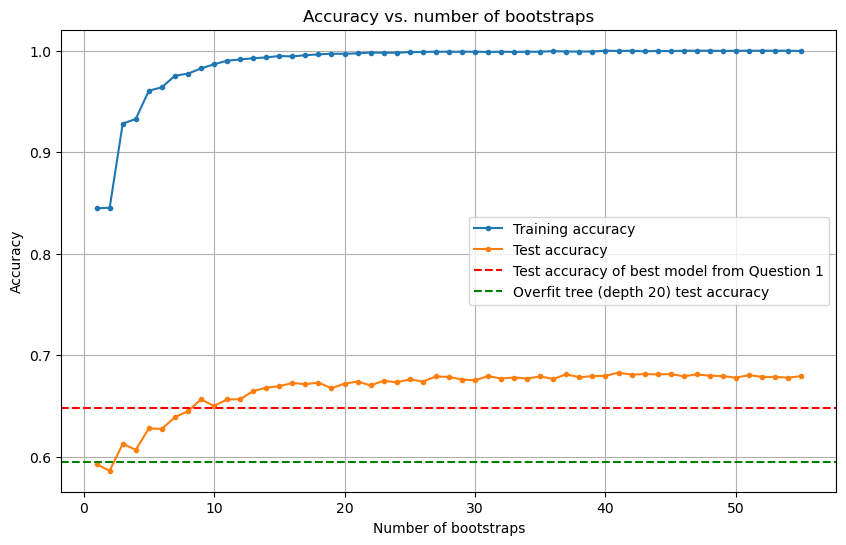

In [20]:
overfit_dt = DecisionTreeClassifier(max_depth=tree_depth, 
                random_state=random_state).fit(X_train,y_train)
overfit_test = overfit_dt.score(X_test,y_test)

running_train = running_predictions(bagging_train_df, 
                                    y_train)
running_test = running_predictions(bagging_test_df, 
                                   y_test)
B = range(1, 56) # no. of bootstraps

plt.figure(figsize=(10, 6))
plt.plot(B, running_train, 
         '.-',
         label="Training accuracy")
plt.plot(B, running_test, 
         '.-',
         label="Test accuracy")
plt.axhline(y=best_cv_tree_test_score, 
            color='r', 
            linestyle='--', 
            label="Test accuracy of best model from Question 1")
plt.axhline(y=overfit_test, 
            color='g', 
            linestyle='--', 
            label="Overfit tree (depth 20) test accuracy")
plt.xlabel("Number of bootstraps")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. number of bootstraps")
plt.legend()
plt.grid()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain what you see in terms of the differences between how bagging and limiting tree depth work to control overfitting.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The performance of bagging is evidently better than the baseline of a single `tree_depth` tree, and bagging also performs better than a single tree with `best_cv_depth`. Bagging surpasses the baseline single `tree_depth` tree after 2 bootstraps and the `best_cv_depth` tree after 8 bootstraps. Around 16 bootstraps is where bagging's test performance plateaus, so bagging is only modestly better than the `best_cv_depth` tree at best regardless of the number of bootstraps, with their scores differing by around 0.03.

One of the key differences between how bagging and limiting tree depth work to control overfitting is in the structure of the model. Bagging allows for unnecessarily complex individual models because, with enough bootstraps, the aggregate of the models will correct the major mistakes. Furthermore, bagging doesn't always result in significant increases in performance when increasing the number of bootstraps. Limiting tree depth doesn't utilize bootstrapping but cross-validation instead, and the result is a less computationally expensive single estimator.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<a id="part3"></a>

## <div class='exercise'>Question 3: Random Forests</div> 

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2, and set the maximum number of features to use when looking for the best split to be the square root of the total number of features. Evaluate classifier's accuracy on the training and test sets and store them in `random_forest_train_score` and `random_forest_test_score`.

</div>

In [21]:
# evaluate results
rf = RandomForestClassifier(n_estimators=n_trees,
                            max_depth=tree_depth,
                            max_features='sqrt',
                            random_state=random_state).fit(X_train,y_train)

random_forest_train_score = rf.score(X_train, y_train)
random_forest_test_score = rf.score(X_test, y_test)

In [22]:
# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-20 and 55 trees achieves the following accuracy scores:

	train	1.0000
	TEST	0.6894


In [23]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.2** Among all of the decision trees you fit in the bagging process (i.e. each of the fitted model objects stored in `bagging_models_list`), how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Dataframes called `top_predictors_bagging` and `top_predictors_rf`, and display them.

What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs. random forest?

**HINT:** A decision tree's top feature is stored as `.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.
    
**IMPORTANT:** As always, your output should be easy to interpret. In this context that means construcing your DataFrames with the care, assigning appropriate column names and/or index values to best convey to the reader what the output represents.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In bagging, feature 25 is the only feature used as the top node for all 55 trees. In the random forest, there is more variety of features used as the top node—with feature 25 used 10 times, followed by feature 27 with 9 times, and so on. This difference is caused by the random subsampling of features at each node of the random forest, so there will be trees in the random forest where feature 25 was not in the sample of features for the first node.

The implication for accuracy is that random forest is likely to be more accurate than bagging, as it can generalize better. Bagging usually relies heavily on a few important features, in this case, primarily one, which may lead to some overfitting (or more bias at the very least). On the other hand, random forests distribute feature importance more evenly, which can improve generalization and reduce the risk of overfitting. As a result, random forests are more likely to have better accuracy and robustness and generalize better compared to bagging in scenarios where feature importance varies.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [24]:
bag_feat_count = {}
rf_feat_count = {}

for t in bagging_models_list:
    top_feature = t.tree_.feature[0]
    if top_feature not in bag_feat_count:
        bag_feat_count[top_feature] = 0
    bag_feat_count[top_feature] += 1

top_predictors_bagging = pd.DataFrame(list(bag_feat_count.items()), 
                                      columns = ['Bagging Feature Number', 
                                               'Count'])
top_predictors_bagging.sort_values(by = 'Count', 
                                   ascending=False, 
                                   inplace=True)
top_predictors_bagging.set_index('Bagging Feature Number', 
               inplace=True)

display(top_predictors_bagging)

for t in rf.estimators_:
    top_feature = t.tree_.feature[0]
    if top_feature not in rf_feat_count:
        rf_feat_count[top_feature] = 0
    rf_feat_count[top_feature] += 1


top_predictors_rf = pd.DataFrame(list(rf_feat_count.items()), 
                                 columns = ['Random Forest Feature Number', 
                                          'Count'])

top_predictors_rf.sort_values(by = 'Count', 
                              ascending = False, 
                              inplace = True)
top_predictors_rf.set_index('Random Forest Feature Number', 
               inplace=True)
display(top_predictors_rf)

,Count
Bagging Feature Number,
25,55


,Count
Random Forest Feature Number,
25,10
27,9
26,8
22,7
24,6
0,4
3,2
12,2
10,1


In [25]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.3**: Make a Pandas DataFrame (following the expected structure shown below) of the training and test accuracy for the following models and name it `results_df`:

1. Single tree with the best depth chosen by cross-validation (from Question 1)
2. A single overfit tree trained on all data (from Question 2, using the depth you chose there)
3. Bagging 55 such trees (from Question 2)
4. A random forest of 55 such trees (from Question 3.1)

Display your `results_df` dataframe and answer: What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance tradeoff.

**NOTE:** This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.

The expected structure for `results_df` is:  

| classifier | training accuracy | test accuracy |
| --- |  --- | --- |
| single depth-$i$ tree chosen by CV | ... | ... |
| single overfit depth-$k$ tree | ... | ... |
| bagging 55 depth-$k$ trees | ... | ... |
| random forest of 55 depth-$k$ trees | ... | ... |

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Ranking the performance of each model on the training set from worst to best (using the numeration detailed above): 1, 3, then 2 & 4 (the single overfit depth-20 tree had the same training accuracy as the random forest). With the exception of the limited depth tree (roughly 0.7), the classifiers' training accuracies are close to 1.

Ranking the performance of each model on the test set from worst to best (using the numeration detailed above): 2, 1, 3, then 4. The classifiers' test accuracies are around 0.6-0.7. Aside from the limited depth tree, all of the other classifiers saw significant drops from their training accuracy. 

These relationships make sense, especially between the single decision trees. The decision tree with limited depth has a higher bias and lower variance compared to the decision tree with `depth=20`, as we see the limited depth tree has a significantly lower train accuracy than the `depth=20` tree. The limited-depth decision tree was clearly not overfit, resulting in lower variance, as the difference between its train and test accuracies was significantly more modest than the `depth=20` tree.

Furthermore, bagging and random forest outperforming the individual trees—with the random forest having the highest test accuracy (but the bagging test accuracy was still higher than the limited depth-tree)—also makes sense. Ensemble methods like bagging and random forests usually reduce variance and improve generalization by aggregating multiple models, so we would expect their test performance to be better. The random forest outperforms bagging on the test set, showing that the randomness in feature selection with the random forest can improve model performance. This confirms what we learned in lecture that random forest can reduce the correlation / bias from using features that may be high cardinality, as bagging will always favor the same features, but the random subsampling of features in random forest means other features get a chance to be considered.

One relationship that doesn't make sense initially is bagging's train performance being worse than the single `depth=20` tree. However, when considering the random nature of the bootstrapping (and that some data points might be omitted from the bootstrapped samples), it is plausible that the single decision tree, which has all of the training data to fit on, can outperform the bagging classifier, where the classifier could have substantial amounts of unique data points omitted.

While overfitting leads to high training accuracy, it usually results in poor generalization and accuracy on the test data (in other words, low bias and high variance). Bagging and random forest techniques help reduce the effects of overfitting and achieve a better balance between bias and variance—raising test accuracy.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [26]:
model_names = [
    "single depth-5 tree chosen by CV",
    "single overfit depth-20 tree",
    "bagging 55 depth-20 trees",
    "random forest of 55 depth-20 trees",
]

training_accuracy = [
    best_cv_tree_train_score,
    train_scores[-1], 
    bagging_accuracy_train,
    random_forest_train_score,
]

test_accuracy = [
    best_cv_tree_test_score,
    overfit_test,
    bagging_accuracy_test,
    random_forest_test_score,
]

results_df = pd.DataFrame({
    "classifier": model_names,
    "training accuracy": training_accuracy,
    "test accuracy": test_accuracy,
})

In [27]:
# display results
results_df

,classifier,training accuracy,test accuracy
0,single depth-5 tree chosen by CV,0.6812,0.6480
1,single overfit depth-20 tree,1.0000,0.5948
2,bagging 55 depth-20 trees,0.9996,0.6794
3,random forest of 55 depth-20 trees,1.0000,0.6894


<!-- END QUESTION -->

<a id="part4"></a>
## <div class='exercise'>Question 4: Boosting</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.1** The following code (see code cell below) "attempts" to implement a simplified version of boosting using just two classifiers. However, this implementation has both fuctionality AND stylistic flaws. Imagine that you are a grader for a college course in Data Science. Write a set of grading comments (in the provided Markdown cell) for the student who submitted this code. Point out the flaws in their provided code submission.

You should be able to identify at least 3 logical/functional issues and 3 stylistic issues.

The intended functionality (i.e. expected requirements) of this "attempted" code is to accomplish the following:

1. Fit an initial tree with a maximum depth of 3.
2. Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
3. Fit a second depth-3 decision tree using those sample weights.
4. Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
5. Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**NOTE:** Please do not modify anything in the code cell itself.

</div>

In [28]:
# RUN THIS CELL
# "Attempted" boosting implementation

def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

## Functional Issues



You should be able to identify at least 3 logical/functional issues and 3 stylistic issues.

The intended functionality (i.e. expected requirements) of this "attempted" code is to accomplish the following:

Fit an initial tree with a maximum depth of 3.
Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
Fit a second depth-3 decision tree using those sample weights.
Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.2** Now, imagine that you are the Teaching Fellow responsible for writing the "solutions" code for the simplified version of boosting using just two classifiers that had been "attempted" in Question 4.1:

- Write an **excellent** example implementation from scratch (i.e. using just scikit-learn's `DecisionTreeClassifier` and NumPy to perform your boosting). Your implementation should be written either [functionally](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) or as a [class](https://docs.python.org/3/tutorial/classes.html), such that you can then call the function(s) or class methods to generate your predictions and/or accuracy scores.

- Report on the performance of your boosting algorithm by printing the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.


</div>

In [29]:
# your code here
class BoostedTreesClassifier:
    def __init__(self, depth):
        self.depth = depth
        self.tree1 = None
        self.tree2 = None

    def fit(self, X_train, y_train):
        # Fit first tree
        self.tree1 = DecisionTreeClassifier(max_depth=self.depth)
        self.tree1.fit(X_train, y_train)

        # Calculate errors and update sample weights (2 is wrong, 1 is right)
        errors = self.tree1.predict(X_train) != y_train
        sample_weights = np.ones_like(y_train, dtype=float)
        sample_weights[errors] = 2

        # Fit second tree with sample weights
        self.tree2 = DecisionTreeClassifier(max_depth=self.depth)
        self.tree2.fit(X_train, y_train, sample_weight=sample_weights)

    def predict(self, X):
        # Predict off of average probabilities of both trees
        proba1 = self.tree1.predict_proba(X)
        proba2 = self.tree2.predict_proba(X)
        avg_proba = (proba1 + proba2) / 2
        return np.argmax(avg_proba, axis=1)

    def score(self, X, y_true):
        # Calculate accuracy
        predictions = self.predict(X)
        return np.mean(predictions == y_true)


# Initialize and fit model
model = BoostedTreesClassifier(3)
model.fit(X_train, y_train)

# Get predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Get accuracies
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
initial_train_accuracy = np.mean(model.tree1.predict(X_train) == y_train)
initial_test_accuracy = np.mean(model.tree1.predict(X_test) == y_test)

print(f"Initial tree training accuracy: {initial_train_accuracy}")
print(f"Initial tree test accuracy: {initial_test_accuracy}")
print(f"Boosting ensemble training accuracy: {train_accuracy}")
print(f"Boosting ensemble test accuracy: {test_accuracy}")


Initial tree training accuracy: 0.6418
Initial tree test accuracy: 0.6442
Boosting ensemble training accuracy: 0.6488
Boosting ensemble test accuracy: 0.651


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.3** Now, let us use the scikit-learn implementation of AdaBoost. For the sake of simplicity we'll use a single validation split for hyperparameter tuning.
    
Use `AdaBoostClassifier` to fit another ensemble to the reduced training set, `X_train80`. Use a decision tree of depth-3 as the base learner, a learning rate 0.05, the default algorithm `SAMME.R`, and run the boosting for 800 iterations. Make a plot of the effect of the number of iterations on the model's train and validation accuracy.

**HINT:** The `.staged_score(...)` method provides the accuracy numbers you'll need for plotting. You'll need to use `list(...)` to convert the "generator" that `staged_score` returns into an ordinary list.

</div>

In [30]:
# Create a train/validation split for hyperparameter tuning
X_train80, X_val, y_train80, y_val = train_test_split(X_train,
                                                      y_train,
                                                      train_size=.8,
                                                      random_state=0,
                                                      stratify=y_train)

In [31]:
# your code here
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), 
                           n_estimators=800, 
                           learning_rate=0.05,
                           random_state=0).fit(X_train80, y_train80)

train_score = list(ada.staged_score(X_train80, y_train80))
val_score = list(ada.staged_score(X_val, y_val))

/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


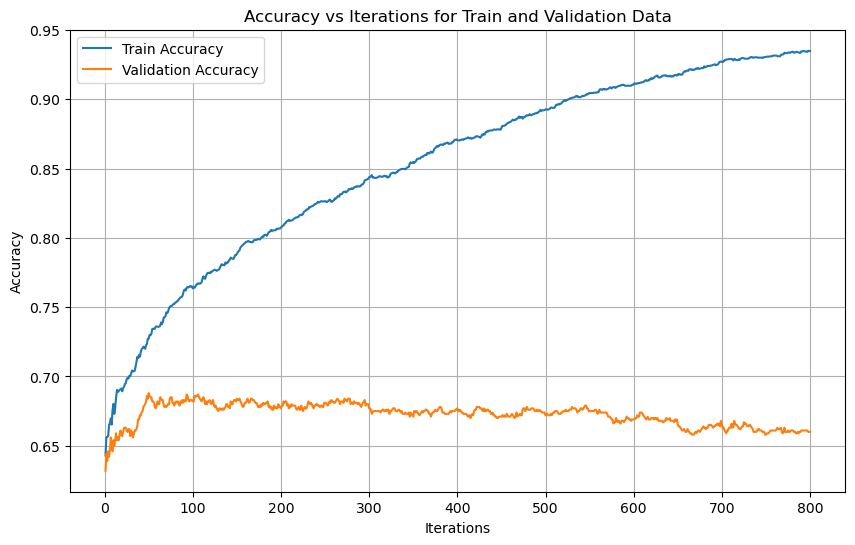

In [32]:
# your code here
iterations = range(1, 801)
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_score, label="Train Accuracy")
plt.plot(iterations, val_score, label="Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iterations for Train and Validation Data")
plt.legend()
plt.grid()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.4** Repeat the plot above for a base learner with depths of 1, 2, 3, and 4. For easier comparison you should arrange your plots in a row. What trends do you see in the training and validation accuracies and how would you explain this behavior?

**NOTE:** It is okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

**Training Accuracies**

As to be expected of an Adaboost classifier, the training accuracy increases as the number of increases. This is because boosting algorithms steadily improve their training accuracy by fitting new classifiers that scrutinize the sample data for which previous classifiers incorrectly classified. Looking at each plot indiviudally we see that after 800 iterations the depth 1 classifier reaches a max training accuracy of approx. 71%, the depth 2 classifier reaches a max training accuracy of approx. 82%, the depth 3 classifier a max training accuracy of 93% and the depth 4 classifier, a nearly perfect max training accuracy of 100%.

**Validation Accuracies**
For the Adaboost classifier's validation accuracy performance over 800 iterations, our findings vary far more.

At a max depth of 1 and 2, the validation accuracy increases as the number of iterations increase, exhibiting exponential decay towards what appears to be a max accuracy of 67% and 68% respectively after 800 iterations. These findings suggests two things: that 67% and 68% are maximum predictive potential of our depth 1 classifier and that our tree is too shallow/simple.

At a max depth of 3 and 4, the validation accuracy increases quickly to a max validation accuracy of approx. 69% for both classifiers after about 75 iterations and 50 iterations respectively. Then, validation accuracy decreases in a linear manner, for iterations greater than 75 and 50 for the depth 3 and 4 classifiers respecrtively. This decreasing behavior exhibited by these classifiers suggests that there may be some overfitting which is causing the reduced performance for iterations greater than 75 and 50 for the two classifiers.

We can conclude that for the validation accuracies that the classifiers of max depth 1 and 2 may be underfitting and that the classifiers of max depth 3 and 4 may be overfitting.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [33]:
# your code here
train_scores = []
val_scores = []

depths = range(1, 5)
for depth in depths:
    ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=depth), 
                           n_estimators=800, 
                           learning_rate=0.05,
                           random_state=0).fit(X_train80, y_train80)
    train_scores.append(list(ada.staged_score(X_train80, y_train80)))
    val_scores.append(list(ada.staged_score(X_val, y_val)))

/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.

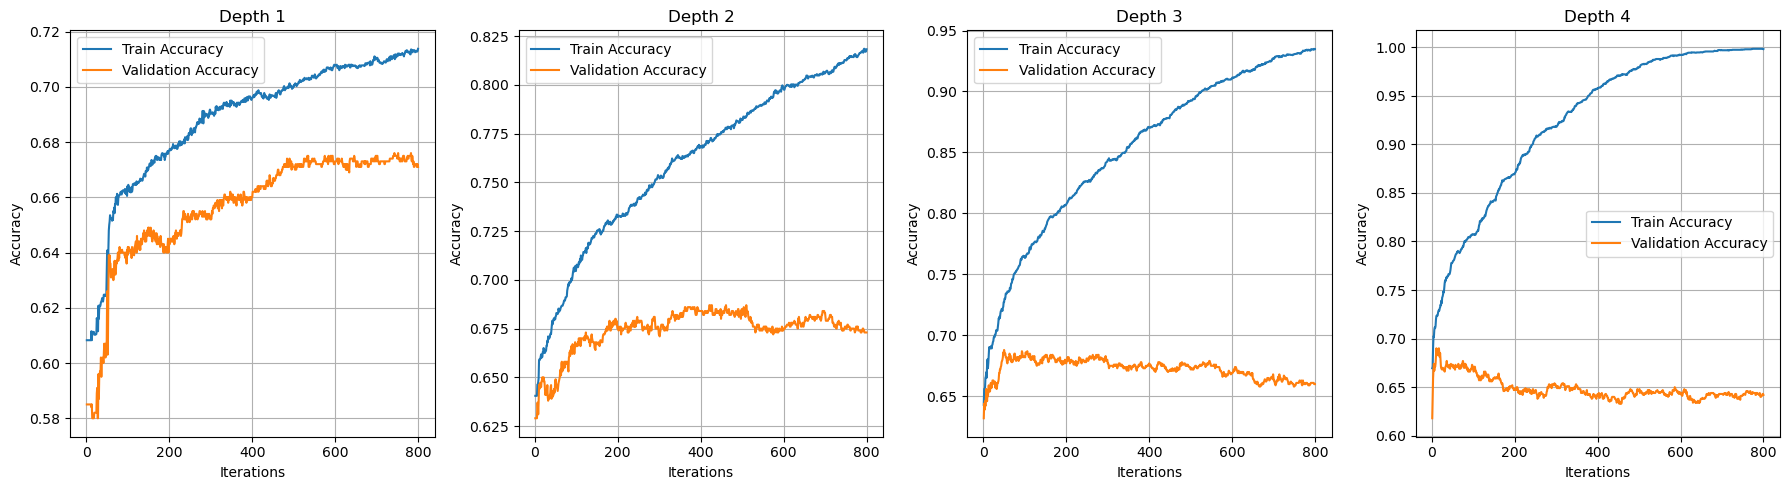

In [34]:
# your code here
fig, axes = plt.subplots(nrows=1, ncols=len(depths), figsize=(18, 5))

for depth in depths:
    i = depth - 1
    axes[i].plot(iterations, train_scores[i], label="Train Accuracy")
    axes[i].plot(iterations, val_scores[i], label="Validation Accuracy")
    axes[i].set_xlabel("Iterations")
    axes[i].set_ylabel("Accuracy")
    axes[i].set_title(f"Depth {depth}")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.5** Based on the plots from Question 4.4, what combination of base learner depth and the number of iterations seems optimal and why?

**Note:** Feel free to make use of additional code to make your decision here if that is helpful. 
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Although the classifier with a max depth of 4 achieves the top validation accuracy of 69.00% after 11 iterations, its complexity raises concerns about overfitting. Simpler models with depths of 2 and 3 also attain similar accuracies of 68.70% and 68.80% respectively, which suggest that they may generalize better generalize to new data. Now comparing the depth-2 and depth-3 classifiers, we find that the depth-3 classifier, reaches 68.80% validation accuracy much faster (which is also marginally higher), achieving this metric after just 50 iterations compared to 421 iterations. In my opinion, the optimal base learner depth and number of iterations should balance accuracy with simplicity to avoid overfitting and ensure efficiency. Therefore, I would opt for the classifier with a base learner depth of 3 which reaches its maximal accuracy after 50 iterations.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [35]:
# Initialize lists for best iterations and optimal validation accuracies
opt_iterations = []
opt_val_accuracies = []

# Find the best combinations
for depth_scores in val_scores:
    max_val_accuracy = max(depth_scores)
    best_iteration = depth_scores.index(max_val_accuracy) + 1
    opt_val_accuracies.append(max_val_accuracy)
    opt_iterations.append(best_iteration)

for depth in range(len(opt_val_accuracies)):
    max_val_accuracy = opt_val_accuracies[depth]
    opt_iteration = opt_iterations[depth]
    print(f"Most optimal number of iterations for depth {depth + 1} is {opt_iteration} iterations with a validation accuracy of {max_val_accuracy:.2%}")


Most optimal number of iterations for depth 1 is 743 iterations with a validation accuracy of 67.60%
Most optimal number of iterations for depth 2 is 421 iterations with a validation accuracy of 68.70%
Most optimal number of iterations for depth 3 is 50 iterations with a validation accuracy of 68.80%
Most optimal number of iterations for depth 4 is 11 iterations with a validation accuracy of 69.00%


In [36]:
opt_depth = 3
opt_iterations = 50

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.6** Fit a final AdaBoostClassifier on the **entire train set** using the base learner depth and number of iterations you identified as optimal in the previous question. Keep the learning rate at 0.05 as before. Store the train and test accuracies in `ada_train_acc` and `ada_test_acc` respectively. How does the performance of this model compare with the performance of the ensemble methods you considered in Question 2 and Question 3?

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Among all the models assessed, the AdaBoost classifier with a max depth of 3 and 50 iterations proves to be the most optimal. It achieves the highest test accuracy while maintaining a balanced trade-off between training and testing accuracies. In contrast, the single depth-5 tree selected through cross-validation, although it has good training accuracy without overfitting, falls short in test performance. Additionally, the single overfitted depth-20 tree, the bagging ensemble with 55 depth-20 trees, and the random forest with 55 depth-20 trees all exhibit severe overfitting, resulting in low test accuracy compared to their training accuracy.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [37]:
# your code here
opt_ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=opt_depth), 
                           n_estimators=opt_iterations, 
                           learning_rate=0.05,
                           random_state=0).fit(X_train, y_train)
ada_train_acc = list(opt_ada.staged_score(X_train, y_train))[-1]
ada_test_acc = list(opt_ada.staged_score(X_test, y_test))[-1]

/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [38]:
model_names = [
    "single depth-5 tree chosen by CV",
    "single overfit depth-20 tree",
    "bagging 55 depth-20 trees",
    "random forest of 55 depth-20 trees",
    "optimal adaboost classifier (max depth = 3, iterations = 50)"
]

training_accuracy = [
    best_cv_tree_train_score,
    train_scores[-1], 
    bagging_accuracy_train,
    random_forest_train_score,
    ada_train_acc
]

test_accuracy = [
    best_cv_tree_test_score,
    overfit_test,
    bagging_accuracy_test,
    random_forest_test_score,
    ada_test_acc
]

results_df = pd.DataFrame({
    "classifier": model_names,
    "training accuracy": training_accuracy,
    "test accuracy": test_accuracy,
})

In [39]:
print(f"Ada Boost Train Accuracy: {ada_train_acc:.2%}")
print(f"Ada Boost Test Accuracy: {ada_test_acc:.2%}")

Ada Boost Train Accuracy: 71.94%
Ada Boost Test Accuracy: 69.98%


<!-- END QUESTION -->

**🌈 This concludes HW6. Thank you!**

[Return to contents](#contents)